# `TauModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `TauModel` model. `TauModel` models the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH and predicts their optical depth spectra.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

from amoeba2 import TauModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.2+0.g883013c.dirty
amoeba2 version: 1.0.0-staging+1.gb634874.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `TauModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"tau_1612", "tau_1665", "tau_1667", and "tau_1720"`.

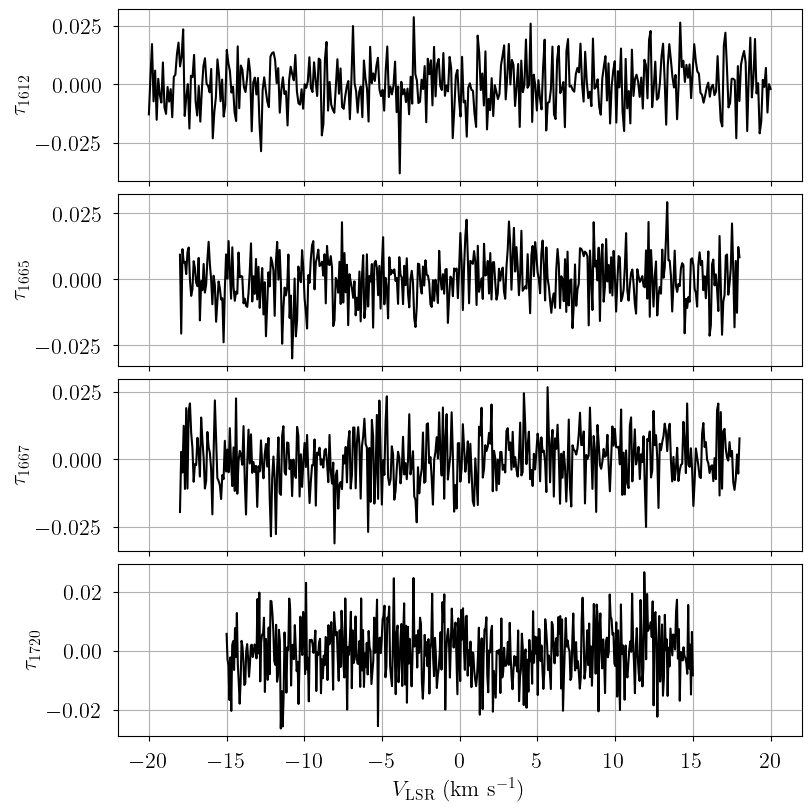

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_tau = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
tau = {label: rms_tau[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"tau_{label}": SpecData(
        velo_axis[label],
        tau[label],
        rms_tau[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )
    for label in velo_axis.keys()
}

# Plot dummy data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = TauModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
# excitation temperature for 1612, 1665, and 1667 MHz
inv_Tex_free = np.array([
    [0.2, -0.2, 0.06], # cloud 0
    [0.06, 0.1, 0.2], # cloud 1
    [0.06, 0.06, 0.1] # cloud 2
])

sim_params = {
    "log10_N_0": np.array([14.0, 14.5, 13.5]),
    "inv_Tex_free": inv_Tex_free,
    "fwhm": np.array([1.2, 1.5, 0.8]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "rms_tau": np.array([0.01, 0.008, 0.012, 0.01]),
}

data = {}
for i, label in enumerate(velo_axis.keys()):
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_tau_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    tau = model.model[f"tau_{label}"].eval(sim_params_label)
    data[f"tau_{label}"] = SpecData(
        velo_axis[label],
        tau,
        sim_params["rms_tau"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )

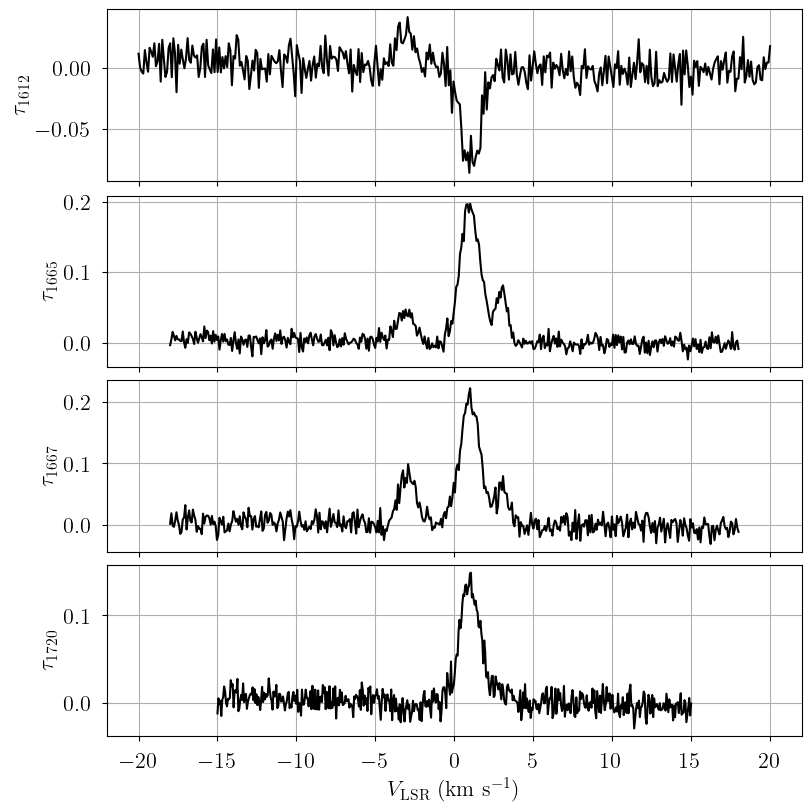

In [5]:
# Plot data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = TauModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 1.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

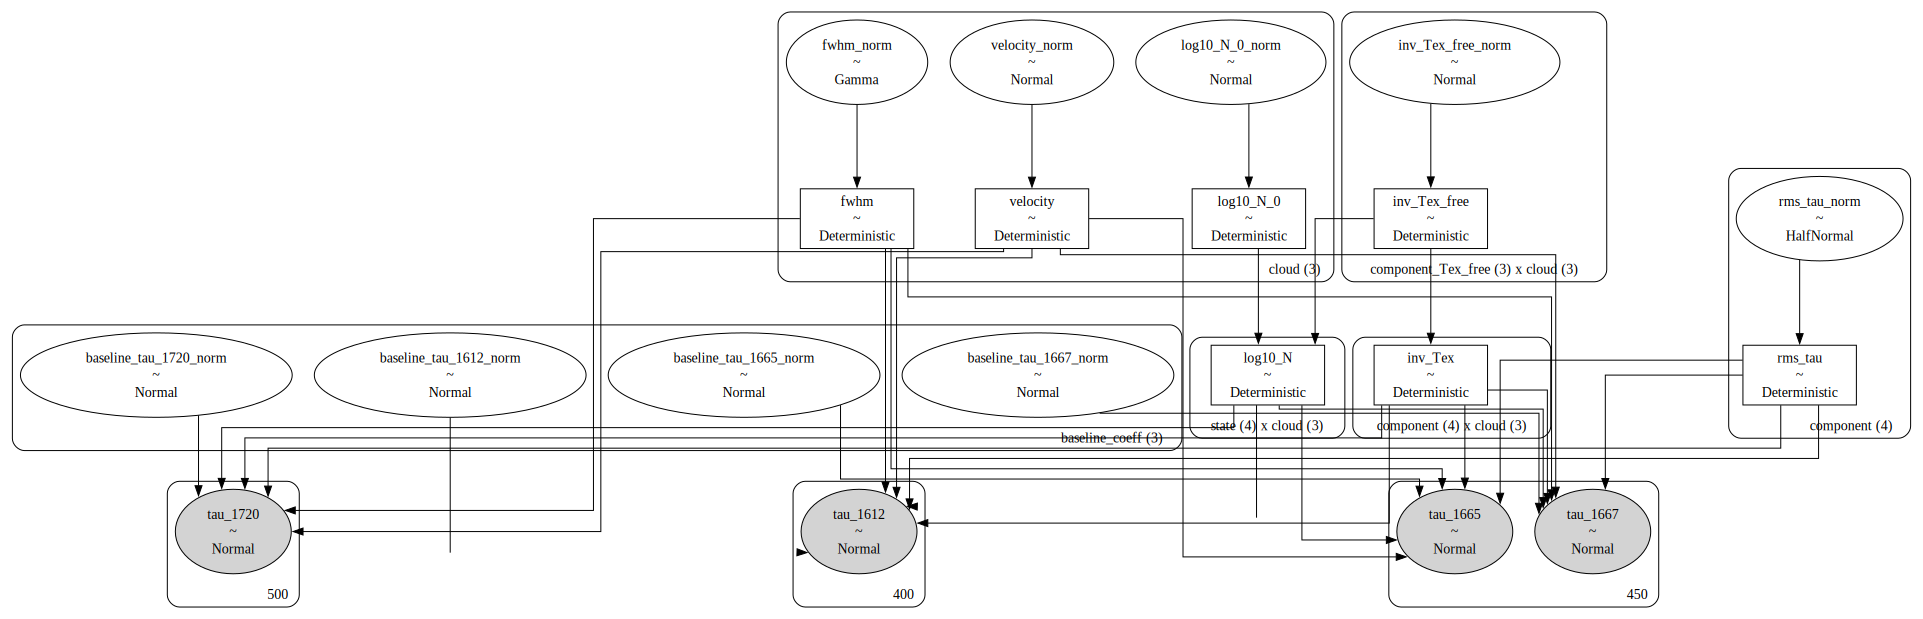

In [7]:
# Plot model graph
gviz = pm.model_to_graphviz(model.model)
gviz.graph_attr["rankdir"] = "TB"
gviz.graph_attr["splines"] = "ortho"
# gviz.graph_attr["newrank"] = "true"
gviz.graph_attr["rank"] = "same"
gviz.graph_attr["ranksep"] = "1.0"
gviz.graph_attr["nodesep"] = "0.3"
gviz.render('tau_model', format='png')
gviz

In [8]:
# model string representation
print(model.model.str_repr())

baseline_tau_1612_norm ~ Normal(0, <constant>)
baseline_tau_1665_norm ~ Normal(0, <constant>)
baseline_tau_1667_norm ~ Normal(0, <constant>)
baseline_tau_1720_norm ~ Normal(0, <constant>)
        log10_N_0_norm ~ Normal(0, 1)
     inv_Tex_free_norm ~ Normal(0, 1)
             fwhm_norm ~ Gamma(2, f())
         velocity_norm ~ Normal(0, 1)
          rms_tau_norm ~ HalfNormal(0, 1)
             log10_N_0 ~ Deterministic(f(log10_N_0_norm))
          inv_Tex_free ~ Deterministic(f(inv_Tex_free_norm))
               inv_Tex ~ Deterministic(f(inv_Tex_free_norm))
               log10_N ~ Deterministic(f(log10_N_0_norm, inv_Tex_free_norm))
                  fwhm ~ Deterministic(f(fwhm_norm))
              velocity ~ Deterministic(f(velocity_norm))
               rms_tau ~ Deterministic(f(rms_tau_norm))
              tau_1612 ~ Normal(f(baseline_tau_1612_norm, log10_N_0_norm, fwhm_norm, velocity_norm, inv_Tex_free_norm), f(rms_tau_norm))
              tau_1665 ~ Normal(f(baseline_tau_1665_norm,

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, fwhm_norm, inv_Tex_free_norm, log10_N_0_norm, rms_tau_norm, tau_1612, tau_1665, tau_1667, tau_1720, velocity_norm]


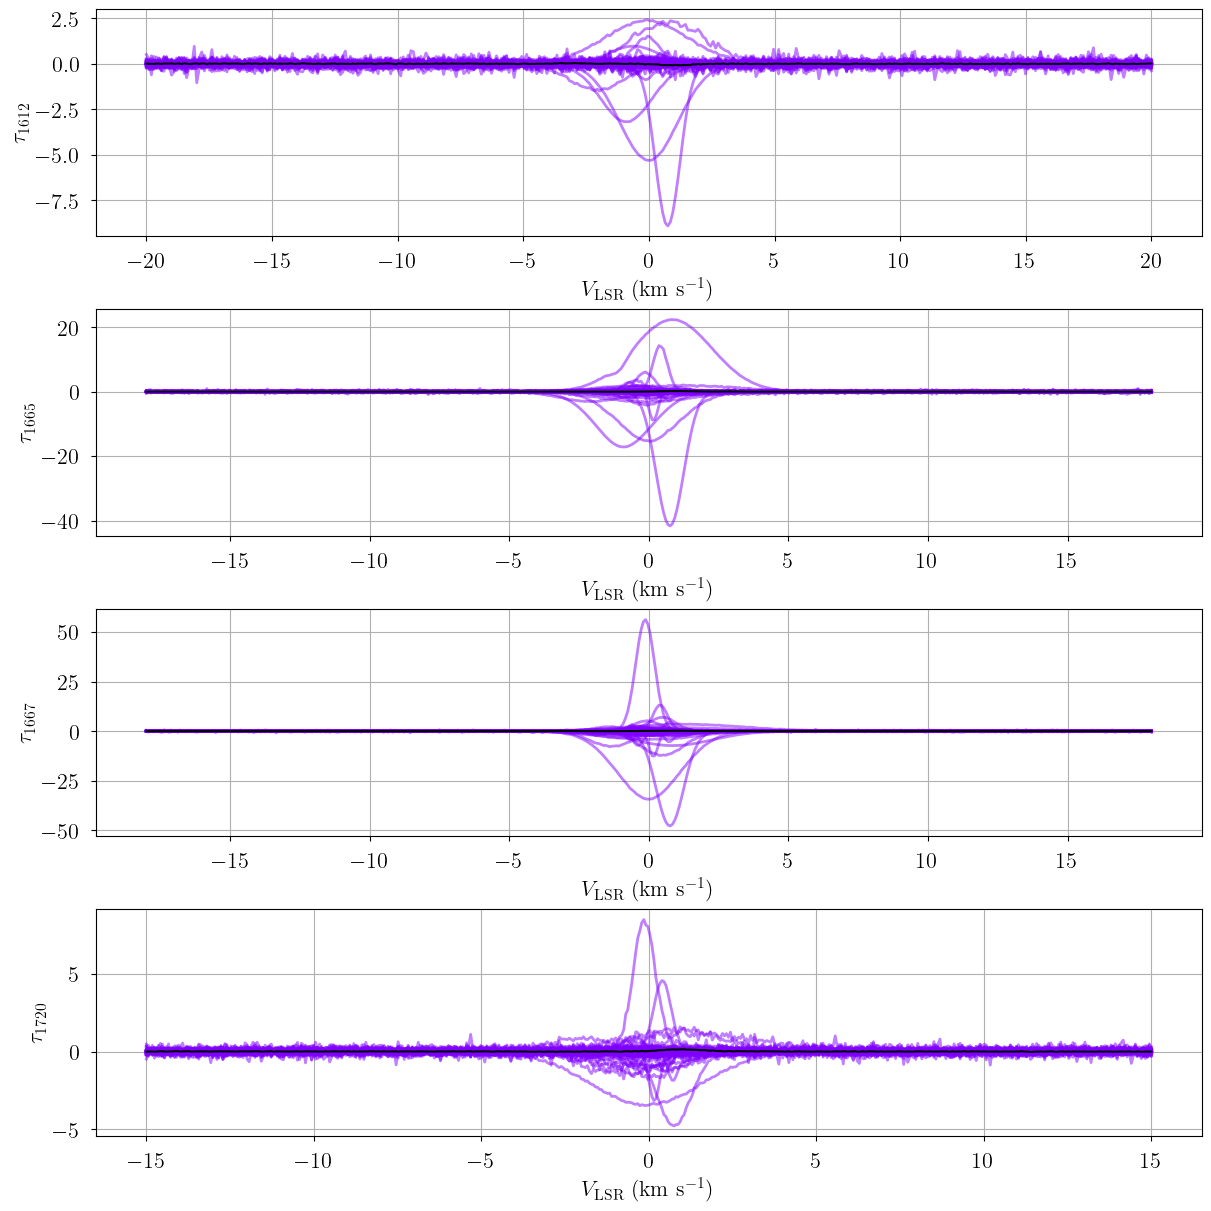

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6300
Interrupted at 6,299 [6%]: Average Loss = -4,813.9


Runtime: 0.58 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_tau_1612_norm[0]    0.070  0.032   0.015    0.133      0.001   
baseline_tau_1612_norm[1]   -0.604  0.108  -0.814   -0.406      0.003   
baseline_tau_1612_norm[2]    1.028  0.556   0.052    2.099      0.018   
baseline_tau_1665_norm[0]   -0.351  0.011  -0.370   -0.327      0.000   
baseline_tau_1665_norm[1]   -0.228  0.039  -0.294   -0.154      0.001   
baseline_tau_1665_norm[2]    0.409  0.232  -0.040    0.813      0.008   
baseline_tau_1667_norm[0]   -0.334  0.016  -0.366   -0.306      0.000   
baseline_tau_1667_norm[1]   -0.287  0.056  -0.391   -0.185      0.002   
baseline_tau_1667_norm[2]   -0.297  0.303  -0.890    0.269      0.010   
baseline_tau_1720_norm[0]   -0.257  0.018  -0.289   -0.224      0.001   
baseline_tau_1720_norm[1]   -0.390  0.058  -0.502   -0.285      0.002   
baseline_tau_1720_norm[2]   -0.181  0.329  -0.789    0.429      0.011   
fwhm[0]                      1.257  0.049   1.166    1.349      0.002   
fwhm[1]                      0.877  0.037   0.808    0.948      0.001   
fwhm[2]                      1.486  0.015   1.457    1.514      0.000   
fwhm_norm[0]                 1.257  0.049   1.166    1.349      0.002   
fwhm_norm[1]                 0.877  0.037   0.808    0.948      0.001   
fwhm_norm[2]                 1.486  0.015   1.457    1.514      0.000   
inv_Tex[1612, 0]             2.885  0.199   2.497    3.231      0.007   
inv_Tex[1612, 1]             0.437  0.268  -0.027    0.973      0.009   
inv_Tex[1612, 2]            -2.858  0.084  -3.019   -2.717      0.003   
inv_Tex[1665, 0]             0.876  0.058   0.764    0.976      0.002   
inv_Tex[1665, 1]             1.451  0.066   1.311    1.560      0.002   
inv_Tex[1665, 2]             1.202  0.015   1.175    1.228      0.000   
inv_Tex[1667, 0]             0.794  0.042   0.719    0.874      0.001   
inv_Tex[1667, 1]             0.726  0.054   0.609    0.814      0.002   
inv_Tex[1667, 2]             0.945  0.016   0.915    0.974      0.001   
inv_Tex[1720, 0]            -1.085  0.200  -1.455   -0.724      0.007   
inv_Tex[1720, 1]             1.698  0.264   1.218    2.189      0.009   
inv_Tex[1720, 2]             4.758  0.082   4.625    4.920      0.003   
inv_Tex_free[1612, 0]        2.885  0.199   2.497    3.231      0.007   
inv_Tex_free[1612, 1]        0.437  0.268  -0.027    0.973      0.009   
inv_Tex_free[1612, 2]       -2.858  0.084  -3.019   -2.717      0.003   
inv_Tex_free[1665, 0]        0.876  0.058   0.764    0.976      0.002   
inv_Tex_free[1665, 1]        1.451  0.066   1.311    1.560      0.002   
inv_Tex_free[1665, 2]        1.202  0.015   1.175    1.228      0.000   
inv_Tex_free[1667, 0]        0.794  0.042   0.719    0.874      0.001   
inv_Tex_free[1667, 1]        0.726  0.054   0.609    0.814      0.002   
inv_Tex_free[1667, 2]        0.945  0.016   0.915    0.974      0.001   
inv_Tex_free_norm[1612, 0]   2.885  0.199   2.497    3.231      0.007   
inv_Tex_free_norm[1612, 1]   0.437  0.268  -0.027    0.973      0.009   
inv_Tex_free_norm[1612, 2]  -2.858  0.084  -3.019   -2.717      0.003   
inv_Tex_free_norm[1665, 0]   0.876  0.058   0.764    0.976      0.002   
inv_Tex_free_norm[1665, 1]   1.451  0.066   1.311    1.560      0.002   
inv_Tex_free_norm[1665, 2]   1.202  0.015   1.175    1.228      0.000   
inv_Tex_free_norm[1667, 0]   0.794  0.042   0.719    0.874      0.001   
inv_Tex_free_norm[1667, 1]   0.726  0.054   0.609    0.814      0.002   
inv_Tex_free_norm[1667, 2]   0.945  0.016   0.915    0.974      0.001   
log10_N[0, 0]               12.816  0.016  12.785   12.844      0.001   
log10_N[0, 1]               12.687  0.016  12.660   12.718      0.000   
log10_N[0, 2]               13.442  0.004  13.434   13.449      0.000   
log10_N[1, 0]               13.104  0.017  13.073   13.137      0.001   
log10_N[1, 1]               12.873  0.018  12.844   12.912      0.001   
log10_N[1, 2]               13.526  0.005  13.517   13.536      0.000   
log10_N[2, 0]  

Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

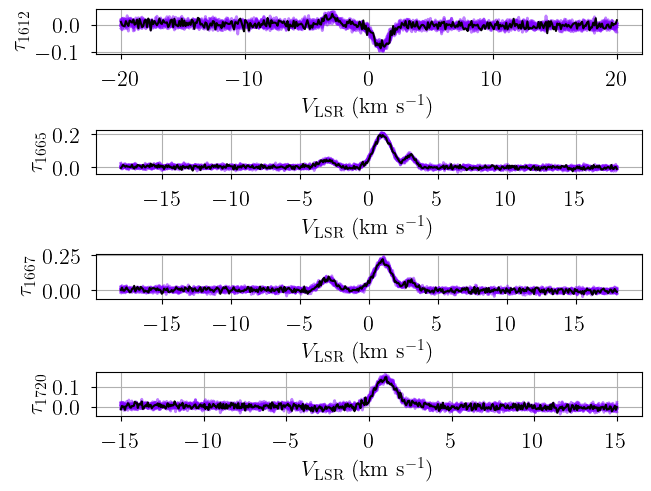

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC. Due to the strong degeneracy between column density and excitation temperature in this optical depth-only model, we may have to increase the number of tuning samples (`tune`) and the NUTS acceptance rate `target_accept` for efficient sampling.

In [14]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6300
Interrupted at 6,299 [6%]: Average Loss = -4,813.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, log10_N_0_norm, inv_Tex_free_norm, fwhm_norm, velocity_norm, rms_tau_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 378 seconds.


There were 104 divergences in converged chains.
Runtime: 7.01 minutes


In [15]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [16]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_tau_1612_norm[0]    0.069  0.041  -0.012    0.140      0.001   
baseline_tau_1612_norm[1]   -0.596  0.097  -0.777   -0.411      0.001   
baseline_tau_1612_norm[2]    1.108  0.690  -0.167    2.397      0.012   
baseline_tau_1665_norm[0]   -0.356  0.019  -0.391   -0.322      0.000   
baseline_tau_1665_norm[1]   -0.233  0.036  -0.300   -0.165      0.001   
baseline_tau_1665_norm[2]    0.415  0.338  -0.202    1.055      0.007   
baseline_tau_1667_norm[0]   -0.337  0.025  -0.383   -0.291      0.000   
baseline_tau_1667_norm[1]   -0.271  0.049  -0.360   -0.174      0.001   
baseline_tau_1667_norm[2]   -0.289  0.430  -1.127    0.475      0.008   
baseline_tau_1720_norm[0]   -0.257  0.026  -0.303   -0.207      0.000   
baseline_tau_1720_norm[1]   -0.377  0.054  -0.481   -0.280      0.001   
baseline_tau_1720_norm[2]   -0.160  0.458  -1.013    0.694      0.008   
fwhm[0]                      1.262  0.053   1.159    1.354      0.001   
fwhm[1]                      0.879  0.043   0.797    0.958      0.001   
fwhm[2]                      1.490  0.018   1.456    1.522      0.000   
fwhm_norm[0]                 1.262  0.053   1.159    1.354      0.001   
fwhm_norm[1]                 0.879  0.043   0.797    0.958      0.001   
fwhm_norm[2]                 1.490  0.018   1.456    1.522      0.000   
inv_Tex[1612, 0]             1.489  0.604   0.364    2.582      0.018   
inv_Tex[1612, 1]             0.429  0.303  -0.085    0.991      0.006   
inv_Tex[1612, 2]            -1.506  0.557  -2.471   -0.574      0.018   
inv_Tex[1665, 0]             0.434  0.187   0.100    0.780      0.006   
inv_Tex[1665, 1]             1.350  0.549   0.366    2.351      0.016   
inv_Tex[1665, 2]             0.670  0.226   0.279    1.067      0.007   
inv_Tex[1667, 0]             0.413  0.164   0.112    0.723      0.005   
inv_Tex[1667, 1]             0.668  0.290   0.155    1.193      0.009   
inv_Tex[1667, 2]             0.468  0.189   0.163    0.803      0.006   
inv_Tex[1720, 0]            -0.575  0.243  -0.994   -0.106      0.007   
inv_Tex[1720, 1]             1.551  0.697   0.354    2.834      0.020   
inv_Tex[1720, 2]             2.514  0.924   1.005    4.169      0.030   
inv_Tex_free[1612, 0]        1.489  0.604   0.364    2.582      0.018   
inv_Tex_free[1612, 1]        0.429  0.303  -0.085    0.991      0.006   
inv_Tex_free[1612, 2]       -1.506  0.557  -2.471   -0.574      0.018   
inv_Tex_free[1665, 0]        0.434  0.187   0.100    0.780      0.006   
inv_Tex_free[1665, 1]        1.350  0.549   0.366    2.351      0.016   
inv_Tex_free[1665, 2]        0.670  0.226   0.279    1.067      0.007   
inv_Tex_free[1667, 0]        0.413  0.164   0.112    0.723      0.005   
inv_Tex_free[1667, 1]        0.668  0.290   0.155    1.193      0.009   
inv_Tex_free[1667, 2]        0.468  0.189   0.163    0.803      0.006   
inv_Tex_free_norm[1612, 0]   1.489  0.604   0.364    2.582      0.018   
inv_Tex_free_norm[1612, 1]   0.429  0.303  -0.085    0.991      0.006   
inv_Tex_free_norm[1612, 2]  -1.506  0.557  -2.471   -0.574      0.018   
inv_Tex_free_norm[1665, 0]   0.434  0.187   0.100    0.780      0.006   
inv_Tex_free_norm[1665, 1]   1.350  0.549   0.366    2.351      0.016   
inv_Tex_free_norm[1665, 2]   0.670  0.226   0.279    1.067      0.007   
inv_Tex_free_norm[1667, 0]   0.413  0.164   0.112    0.723      0.005   
inv_Tex_free_norm[1667, 1]   0.668  0.290   0.155    1.193      0.009   
inv_Tex_free_norm[1667, 2]   0.468  0.189   0.163    0.803      0.006   
log10_N[0, 0]               13.175  0.205  12.819   13.569      0.006   
log10_N[0, 1]               12.771  0.191  12.454   13.143      0.006   
log10_N[0, 2]               13.703  0.147  13.444   13.984      0.005   
log10_N[1, 0]               13.431  0.192  13.106   13.801      0.006   
log10_N[1, 1]               12.960  0.204  12.602   13.345      0.006   
log10_N[1, 2]               13.851  0.173  13.538   14.177      0.006   
log10_N[2, 0]  

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

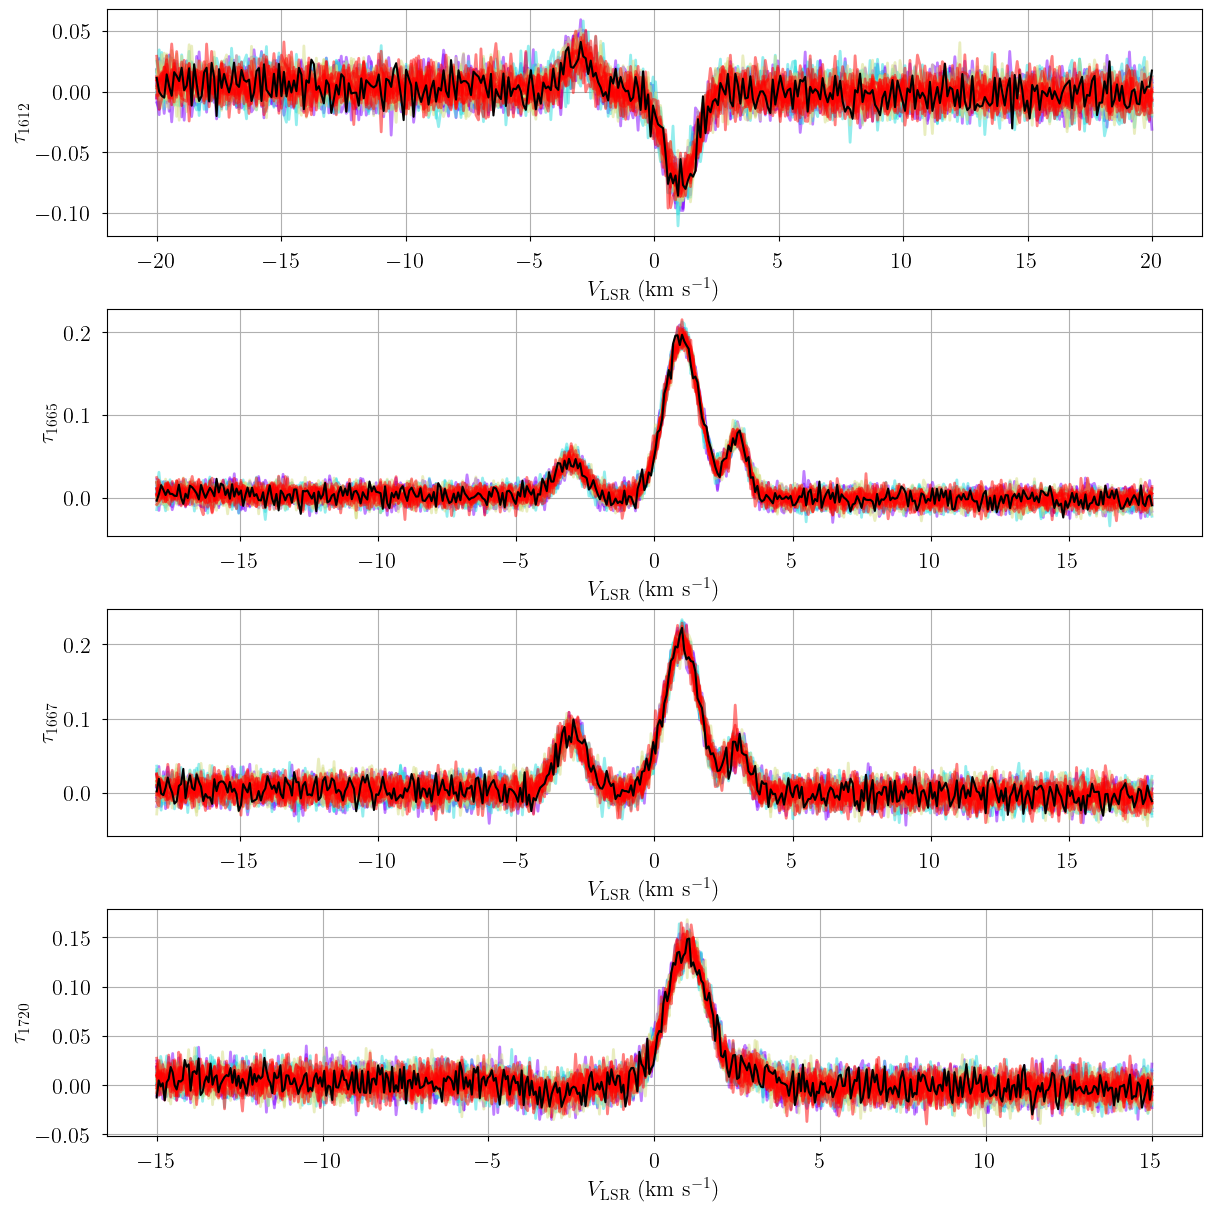

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

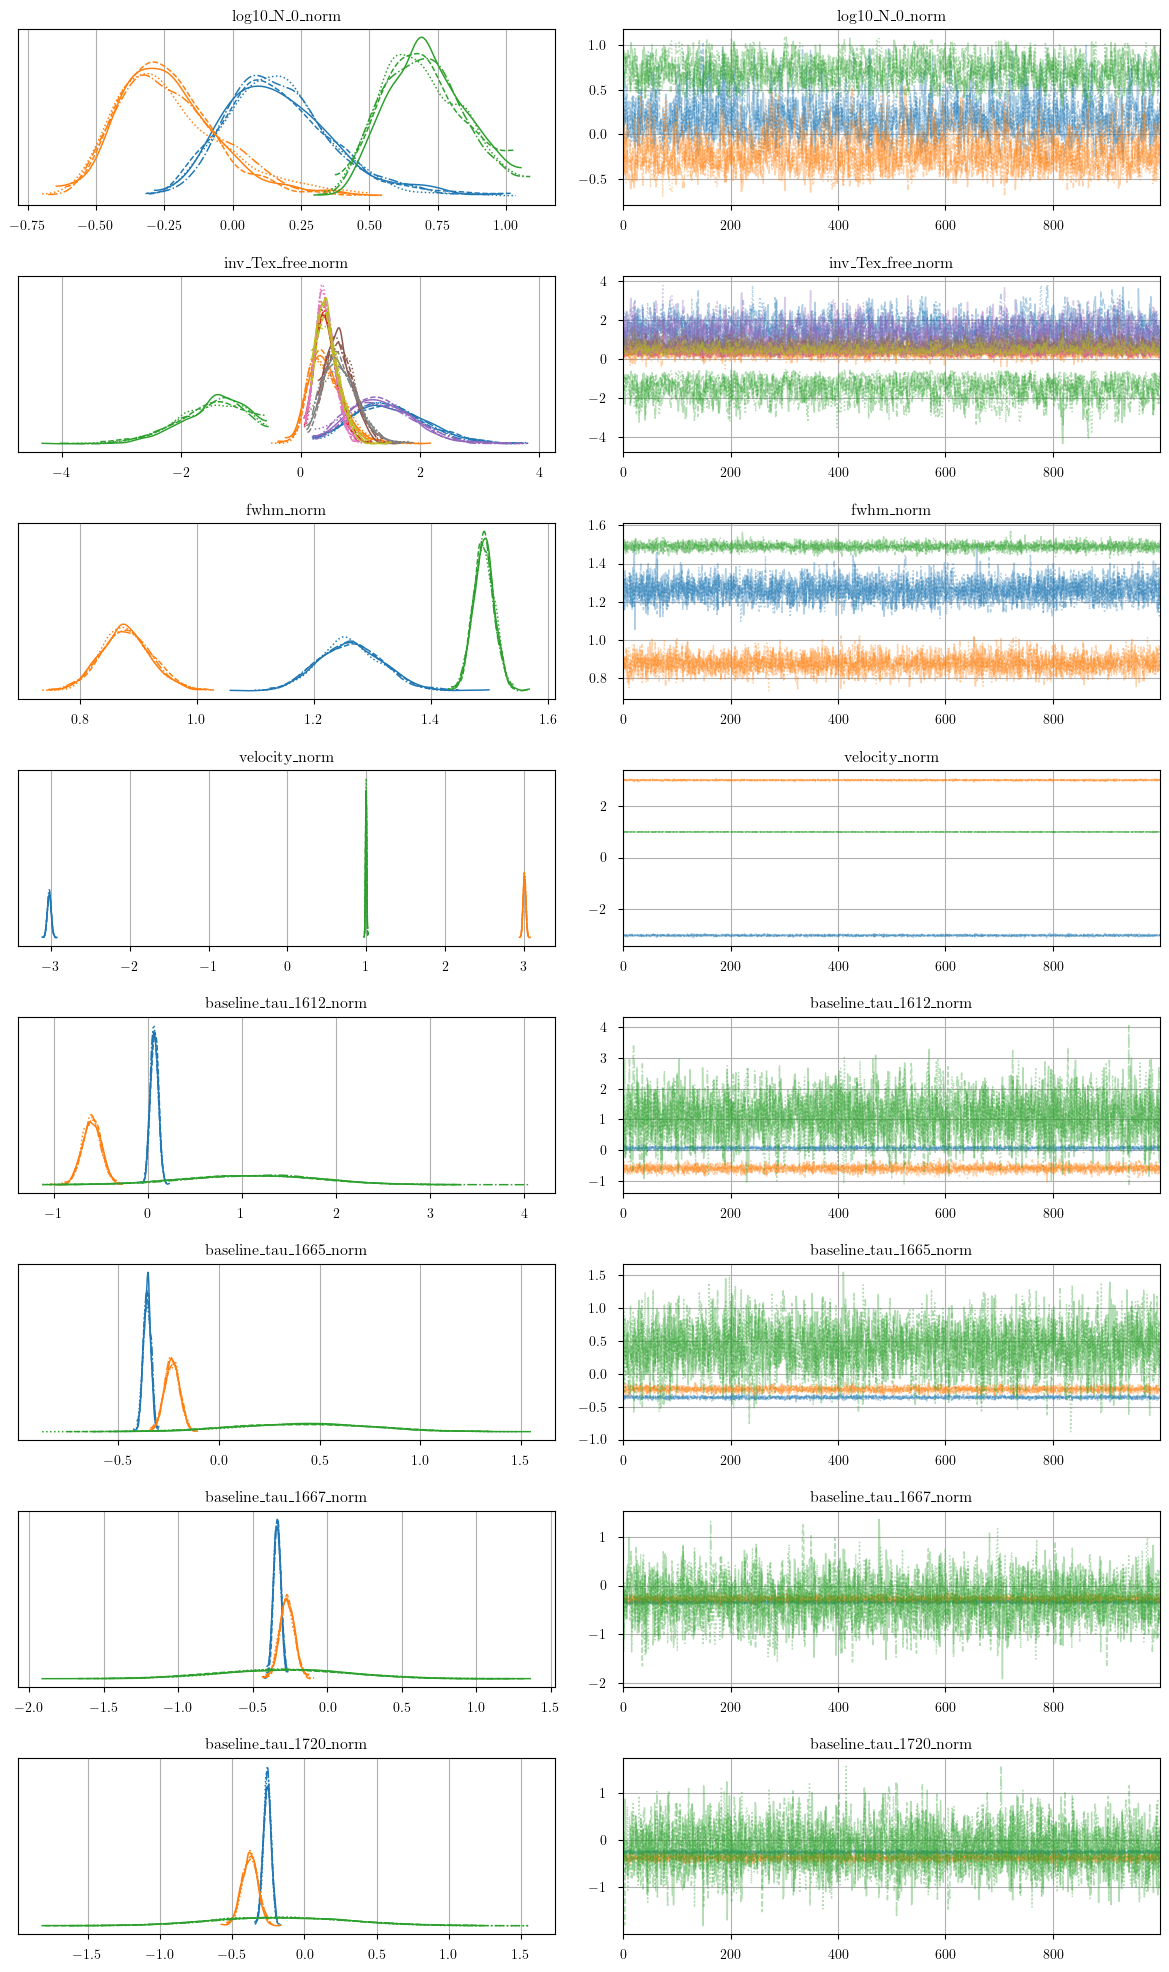

In [18]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
axes.ravel()[0].figure.set_size_inches(12, 20)
axes.ravel()[0].figure.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

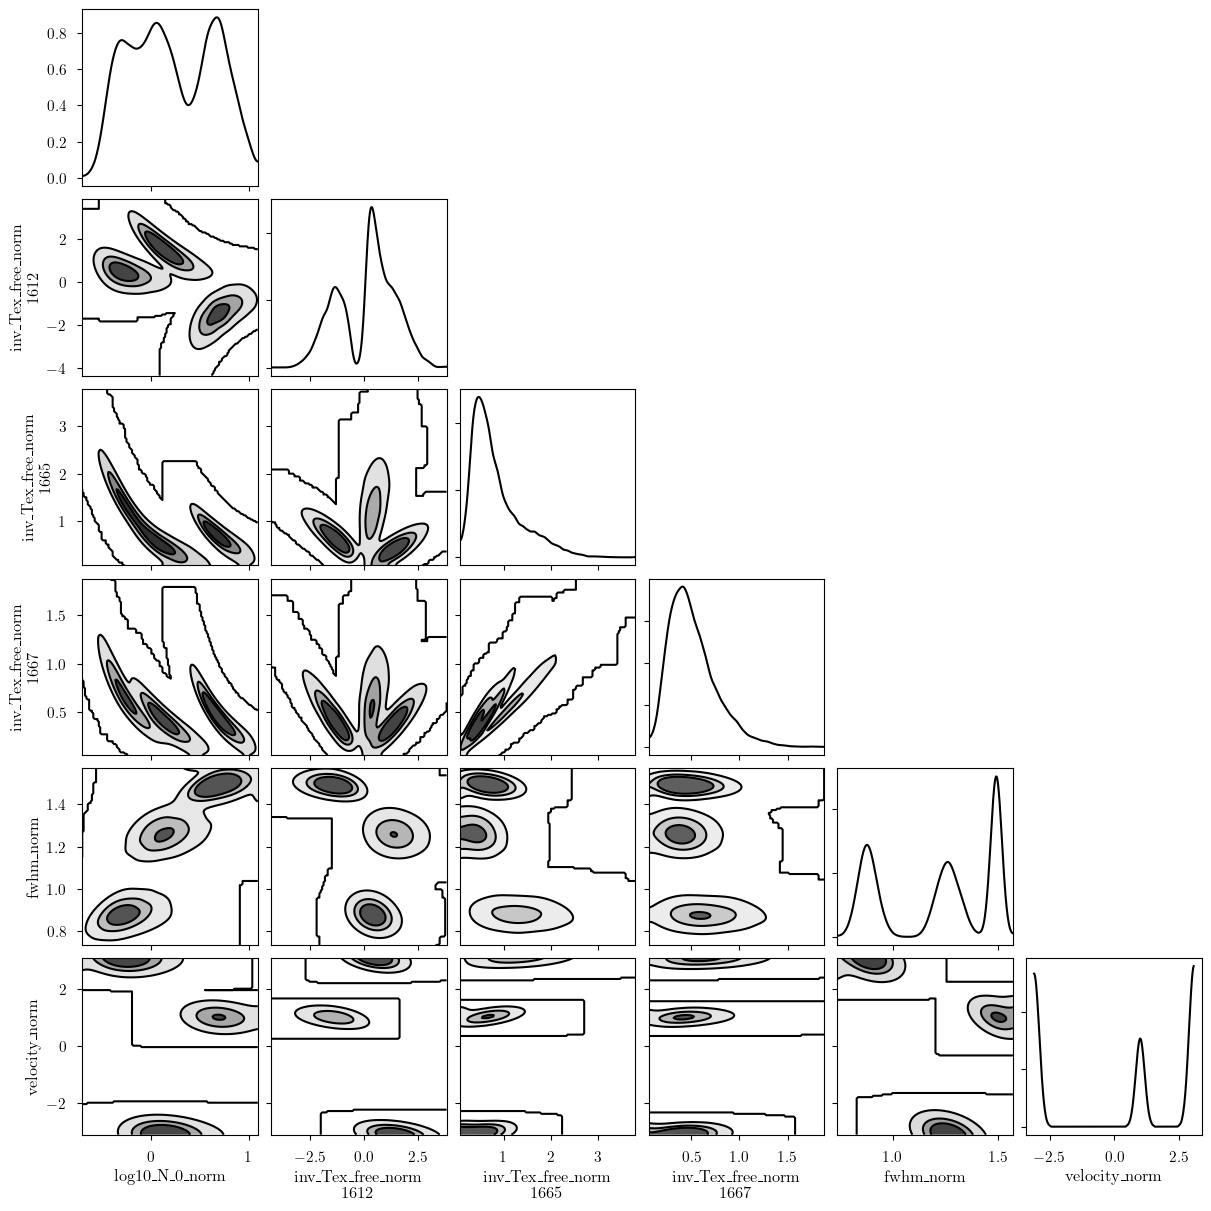

In [19]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. Also notice the tight correlation between column density and excitation temperature: optical depth spectra alone struggle to break this degeneracy!

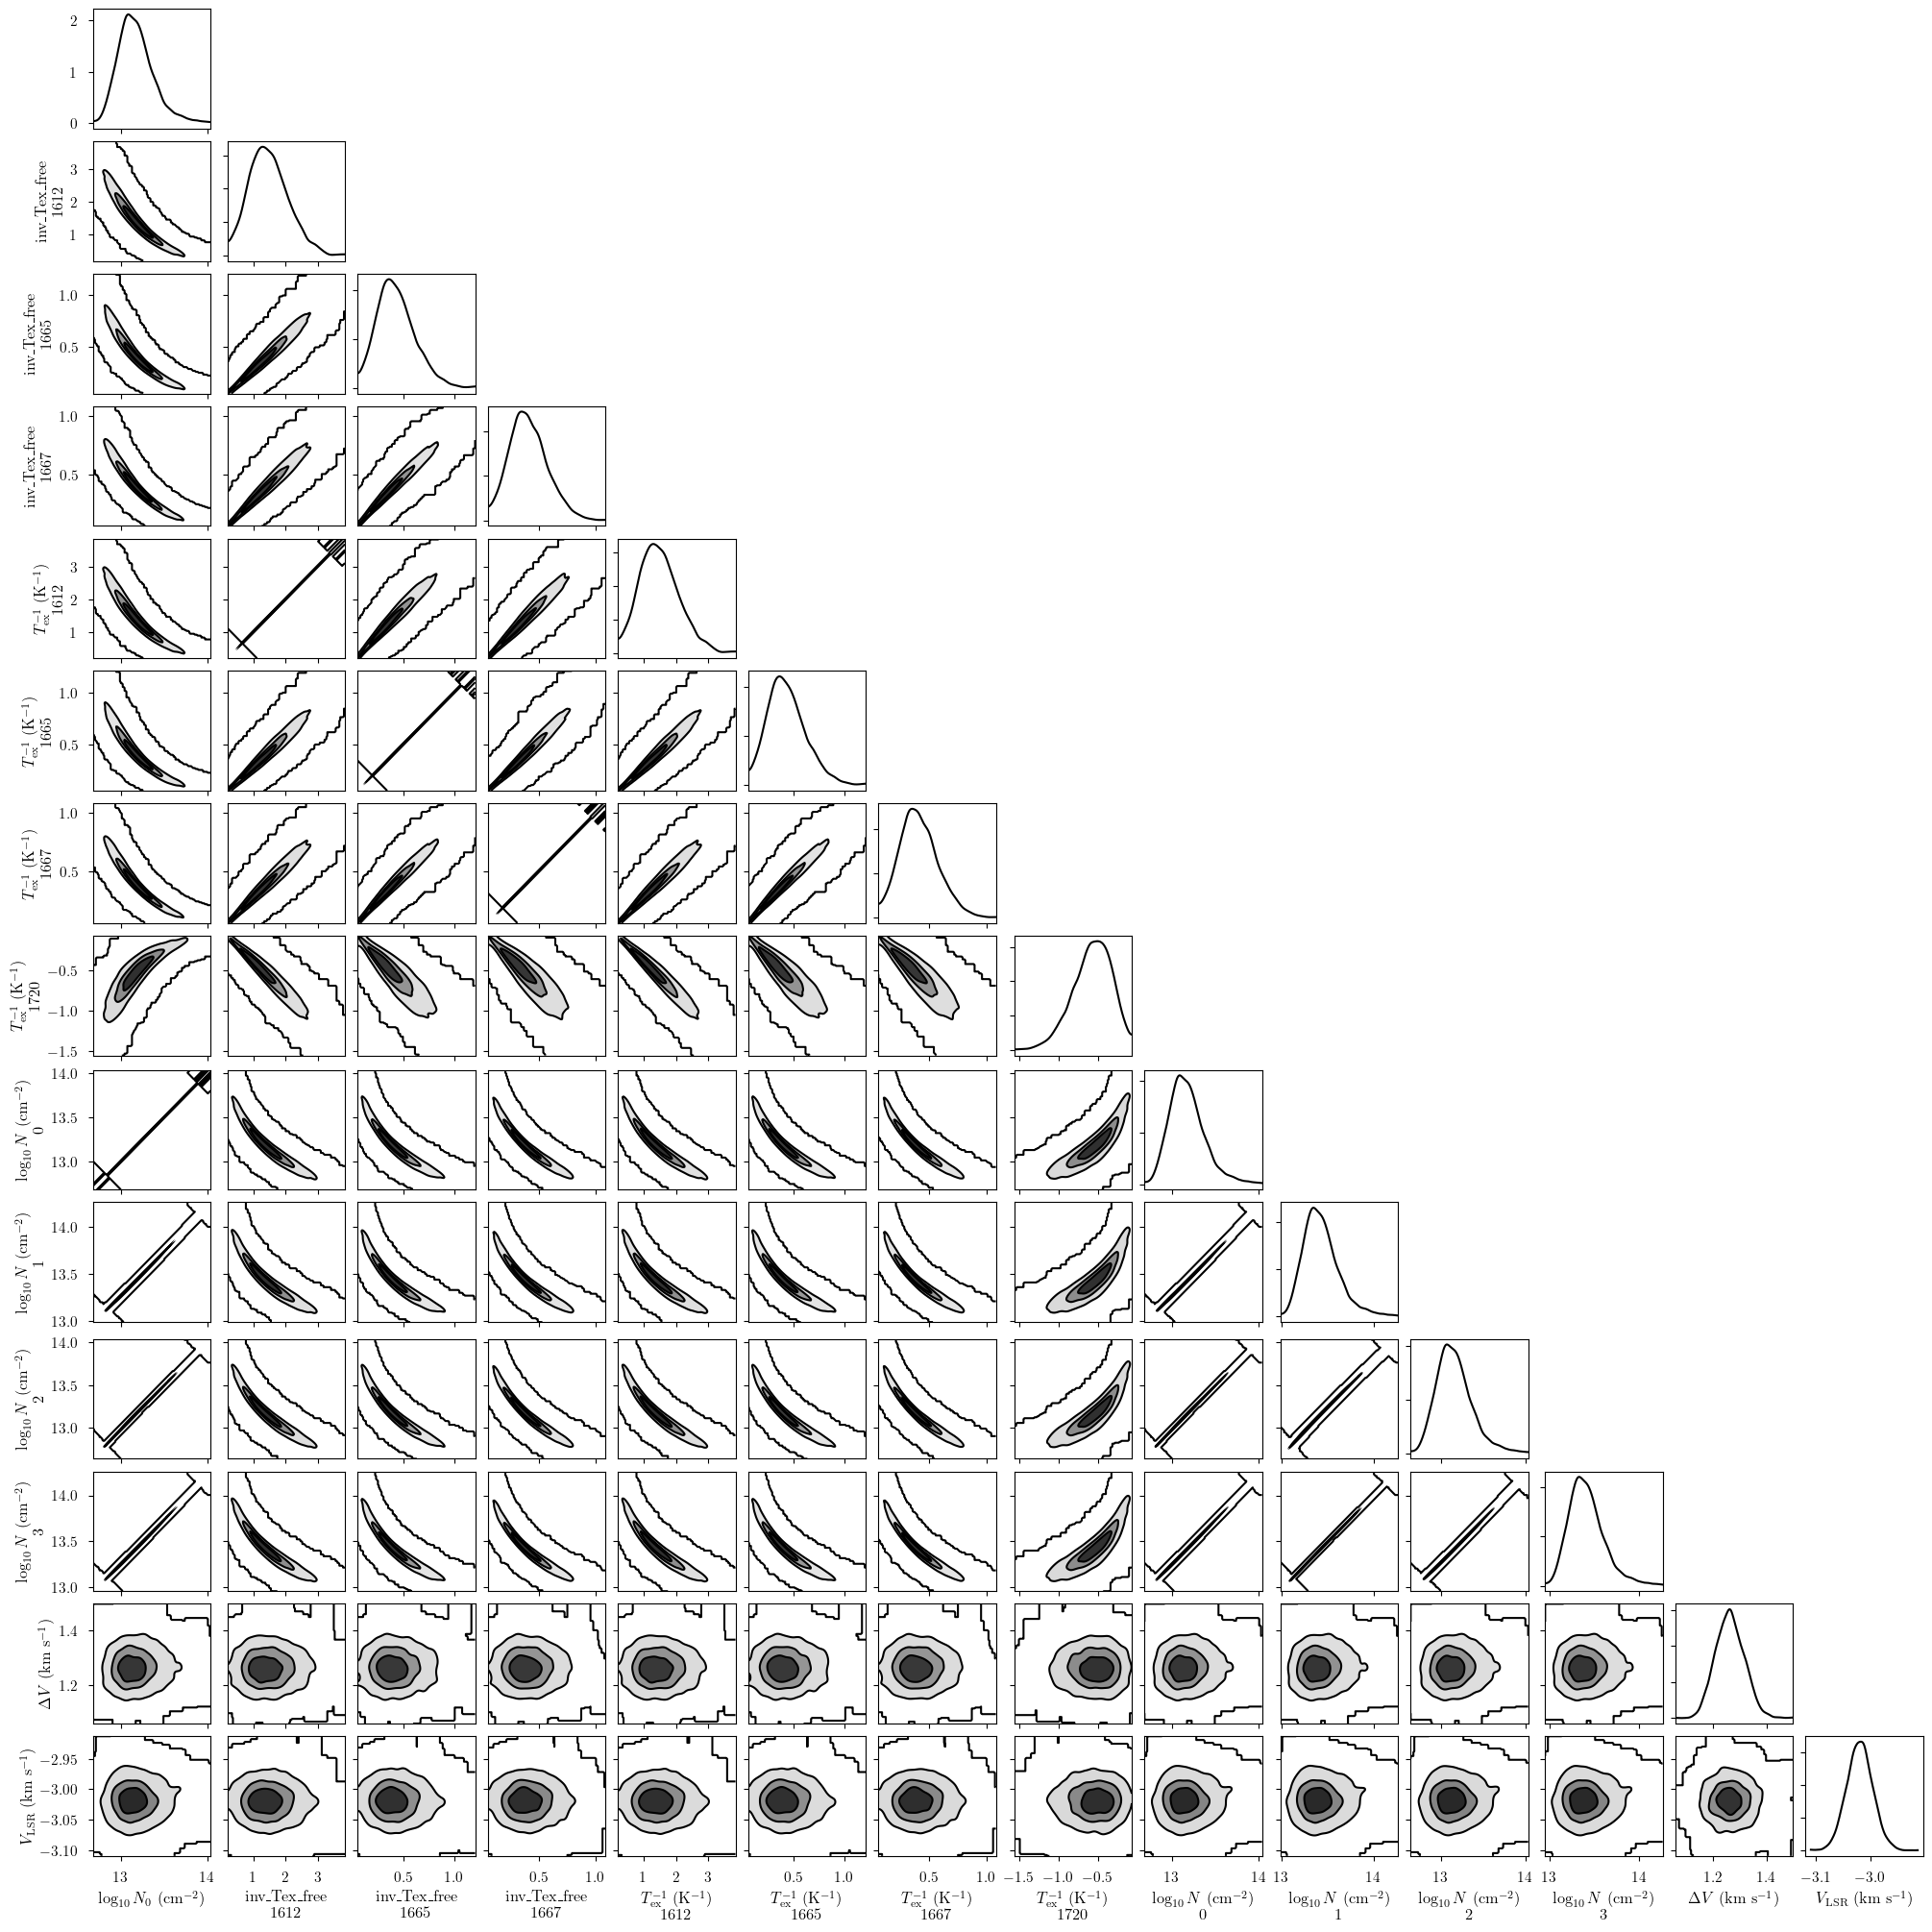

In [20]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(20, 20)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -11133.81272060996


mean     sd  hdi_16%  hdi_84%
baseline_tau_1612_norm[0]    0.069  0.041    0.024    0.106
baseline_tau_1612_norm[1]   -0.596  0.097   -0.697   -0.505
baseline_tau_1612_norm[2]    1.108  0.690    0.448    1.814
baseline_tau_1665_norm[0]   -0.356  0.019   -0.376   -0.338
baseline_tau_1665_norm[1]   -0.233  0.036   -0.271   -0.198
baseline_tau_1665_norm[2]    0.415  0.338    0.075    0.748
baseline_tau_1667_norm[0]   -0.337  0.025   -0.359   -0.310
baseline_tau_1667_norm[1]   -0.271  0.049   -0.318   -0.221
baseline_tau_1667_norm[2]   -0.289  0.430   -0.724    0.121
baseline_tau_1720_norm[0]   -0.257  0.026   -0.286   -0.234
baseline_tau_1720_norm[1]   -0.377  0.054   -0.428   -0.321
baseline_tau_1720_norm[2]   -0.160  0.458   -0.615    0.282
fwhm[0]                      1.262  0.053    1.202    1.310
fwhm[1]                      0.879  0.043    0.830    0.913
fwhm[2]                      1.490  0.018    1.470    1.505
fwhm_norm[0]                 1.262  0.053    1.202    1.310
fwhm_norm[1]                 0.879  0.043    0.830    0.913
fwhm_norm[2]                 1.490  0.018    1.470    1.505
inv_Tex[1612, 0]             1.489  0.604    0.766    1.944
inv_Tex[1612, 1]             0.429  0.303    0.072    0.616
inv_Tex[1612, 2]            -1.506  0.557   -1.942   -0.856
inv_Tex[1665, 0]             0.434  0.187    0.207    0.562
inv_Tex[1665, 1]             1.350  0.549    0.762    1.860
inv_Tex[1665, 2]             0.670  0.226    0.394    0.846
inv_Tex[1667, 0]             0.413  0.164    0.233    0.550
inv_Tex[1667, 1]             0.668  0.290    0.336    0.902
inv_Tex[1667, 2]             0.468  0.189    0.240    0.595
inv_Tex[1720, 0]            -0.575  0.243   -0.746   -0.267
inv_Tex[1720, 1]             1.551  0.697    0.686    2.028
inv_Tex[1720, 2]             2.514  0.924    1.460    3.264
inv_Tex_free[1612, 0]        1.489  0.604    0.766    1.944
inv_Tex_free[1612, 1]        0.429  0.303    0.072    0.616
inv_Tex_free[1612, 2]       -1.506  0.557   -1.942   -0.856
inv_Tex_free[1665, 0]        0.434  0.187    0.207    0.562
inv_Tex_free[1665, 1]        1.350  0.549    0.762    1.860
inv_Tex_free[1665, 2]        0.670  0.226    0.394    0.846
inv_Tex_free[1667, 0]        0.413  0.164    0.233    0.550
inv_Tex_free[1667, 1]        0.668  0.290    0.336    0.902
inv_Tex_free[1667, 2]        0.468  0.189    0.240    0.595
inv_Tex_free_norm[1612, 0]   1.489  0.604    0.766    1.944
inv_Tex_free_norm[1612, 1]   0.429  0.303    0.072    0.616
inv_Tex_free_norm[1612, 2]  -1.506  0.557   -1.942   -0.856
inv_Tex_free_norm[1665, 0]   0.434  0.187    0.207    0.562
inv_Tex_free_norm[1665, 1]   1.350  0.549    0.762    1.860
inv_Tex_free_norm[1665, 2]   0.670  0.226    0.394    0.846
inv_Tex_free_norm[1667, 0]   0.413  0.164    0.233    0.550
inv_Tex_free_norm[1667, 1]   0.668  0.290    0.336    0.902
inv_Tex_free_norm[1667, 2]   0.468  0.189    0.240    0.595
log10_N[0, 0]               13.175  0.205   12.935   13.307
log10_N[0, 1]               12.771  0.191   12.553   12.898
log10_N[0, 2]               13.703  0.147   13.530   13.835
log10_N[1, 0]               13.431  0.192   13.212   13.554
log10_N[1, 1]               12.960  0.204   12.724   13.098
log10_N[1, 2]               13.851  0.173   13.649   14.010
log10_N[2, 0]               13.160  0.212   12.917   13.303
log10_N[2, 1]               12.724  0.209   12.483   12.868
log10_N[2, 2]               13.680  0.155   13.496   13.817
log10_N[3, 0]               13.417  0.198   13.190   13.545
log10_N[3, 1]               12.937  0.214   12.696   13.090
log10_N[3, 2]               13.835  0.180   13.624   13.999
log10_N_0[0]                13.175  0.205   12.935   13.307
log10_N_0[1]                12.771  0.191   12.553   12.898
log10_N_0[2]                13.703  0.147   13.530   13.835
log10_N_0_norm[0]            0.175  0.205   -0.065    0.307
log10_N_0_norm[1]           -0.229  0.191   -0.447   -0.102
log10_N_0_norm[2]            0.703  0.147    0.530    0.835
rms_tau[16